In [1]:
# to import libraries
!pip install matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# to load all cleaned datasets
rawg = pd.read_csv("data/rawg_clean.csv")
steam = pd.read_csv("data/steam_clean.csv")
sales = pd.read_csv("data/vgsales_clean.csv")

In [3]:
# to show basic info
print("RAWG dataset:", rawg.shape)
print("Steam dataset:", steam.shape)
print("Sales dataset:", sales.shape)

RAWG dataset: (1561, 6)
Steam dataset: (25985, 18)
Sales dataset: (12270, 11)


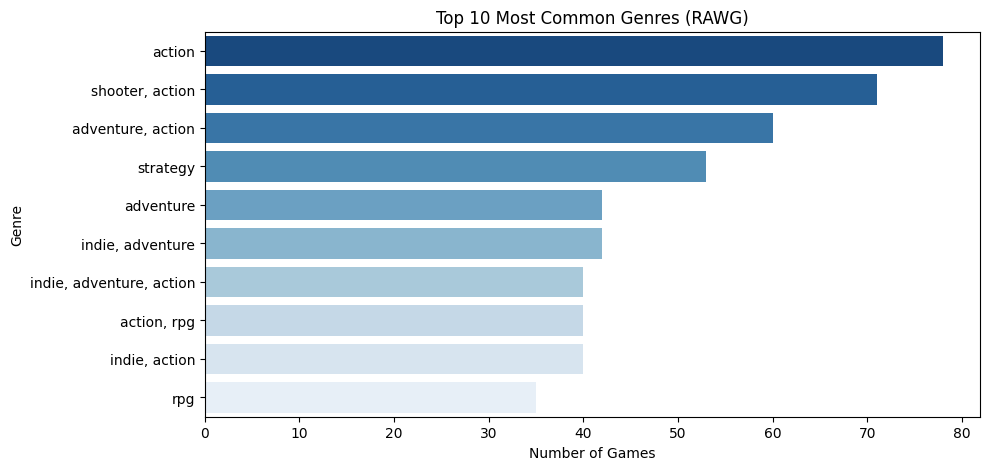

In [45]:
# to analyze RAWG data (Questions 1 and 2)
# Top genres by frequency
genre_counts = rawg['genre'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='Blues_r')
plt.title("Top 10 Most Common Genres (RAWG)")
plt.xlabel("Number of Games")
plt.ylabel("Genre")
plt.show()

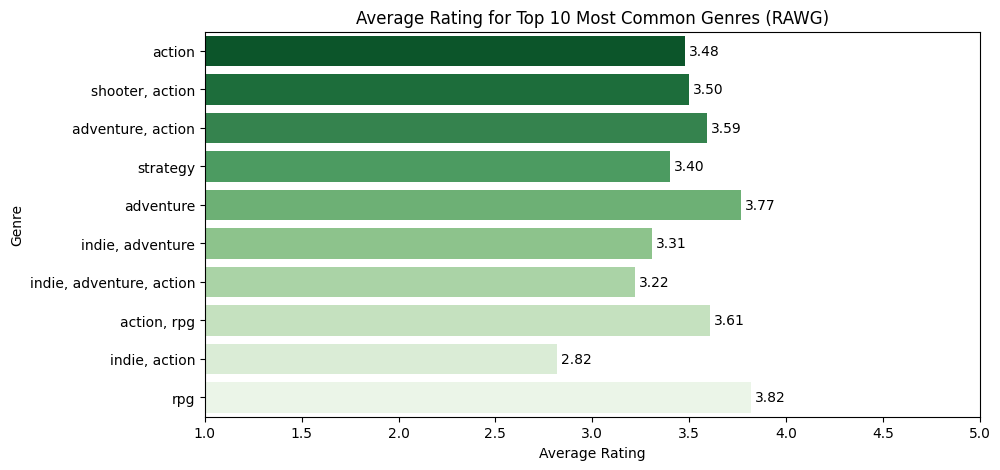

In [46]:
# Average rating by genre (Top 10 most common genres)
# Get only the rows where the genre is one of the top 10
top_genres = genre_counts.index

avg_rating_genre = (
    rawg[rawg['genre'].isin(top_genres)]
    .groupby('genre')['rating']
    .mean()
    .round(2)
)

plt.figure(figsize=(10,5))
sns.barplot(
    x=[avg_rating_genre[g] for g in top_genres],
    y=top_genres,
    palette='Greens_r'
)

# Add labels
for i, g in enumerate(top_genres):
    plt.text(avg_rating_genre[g] + 0.02, i, f'{avg_rating_genre[g]:.2f}', va='center')

plt.title("Average Rating for Top 10 Most Common Genres (RAWG)")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.xlim(1, 5)
plt.show()

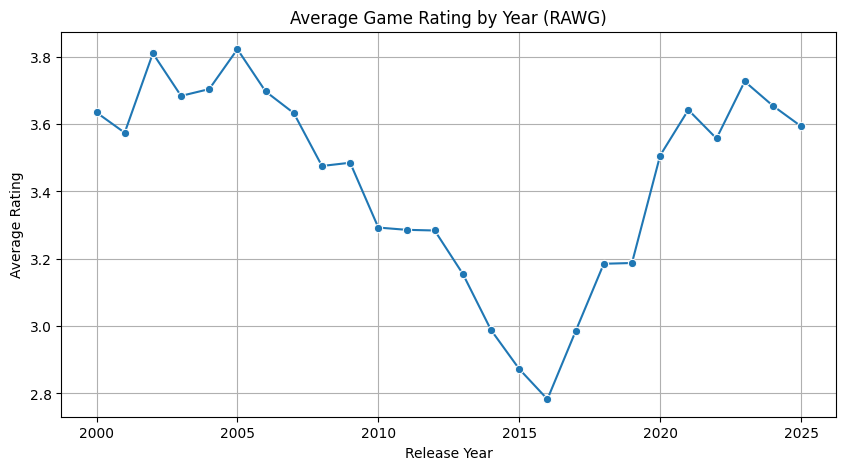

In [47]:
yearly_ratings = rawg.groupby('year')['rating'].mean().dropna()
plt.figure(figsize=(10,5))
sns.lineplot(x=yearly_ratings.index, y=yearly_ratings.values, marker='o')
plt.title("Average Game Rating by Year (RAWG)")
plt.xlabel("Release Year")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()

In [48]:
# Create a stratified random sample by genre (balanced and reproducible)
steam_sample = (
    steam.groupby('genre', group_keys=False)
    .apply(lambda x: x.sample(frac=1, random_state=42))  # ~5% per genre
    .reset_index(drop=True)
)

# Split multiple genres (e.g., "Action;Adventure") into separate rows
steam_split = steam_sample.assign(genre=steam_sample['genre'].str.split(';'))
steam_split = steam_split.explode('genre')
steam_split['genre'] = steam_split['genre'].str.strip().str.lower()

print("Steam sample size:", steam_sample.shape)
print("After splitting genres:", steam_split.shape)
print("Unique genres in sample:", steam_split['genre'].nunique())
print("Top genres:", steam_split['genre'].value_counts().head(10))

Steam sample size: (25985, 18)
After splitting genres: (71935, 18)
Unique genres in sample: 15
Top genres: genre
indie           18772
action          11461
casual           9944
adventure        9619
strategy         5167
simulation       5048
rpg              4167
early access     2796
free to play     1612
sports           1309
Name: count, dtype: int64


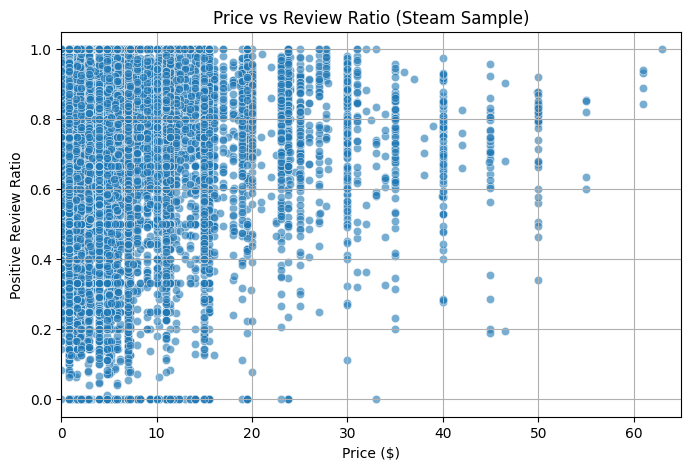

Correlation between price and review ratio: 0.079


In [49]:
# Q3: Do cheaper games tend to receive higher user reviews?


# create a review ratio (positive / total)
steam_sample['total_ratings'] = steam_sample['positive_ratings'] + steam_sample['negative_ratings']
steam_sample['review_ratio'] = steam_sample['positive_ratings'] / steam_sample['total_ratings']

plt.figure(figsize=(8,5))
sns.scatterplot(data=steam_sample, x='price', y='review_ratio', alpha=0.6)
plt.title("Price vs Review Ratio (Steam Sample)")
plt.xlabel("Price ($)")
plt.ylabel("Positive Review Ratio")
plt.grid(True)
plt.xlim(0, 65)
plt.show()

corr = steam_sample[['price', 'review_ratio']].corr().iloc[0,1]
print(f"Correlation between price and review ratio: {corr:.3f}")

Average review ratio by price range:
  price_bin  review_ratio
0      $0–5         0.686
1     $5–15         0.751
2    $15–30         0.758
3      $30+         0.711


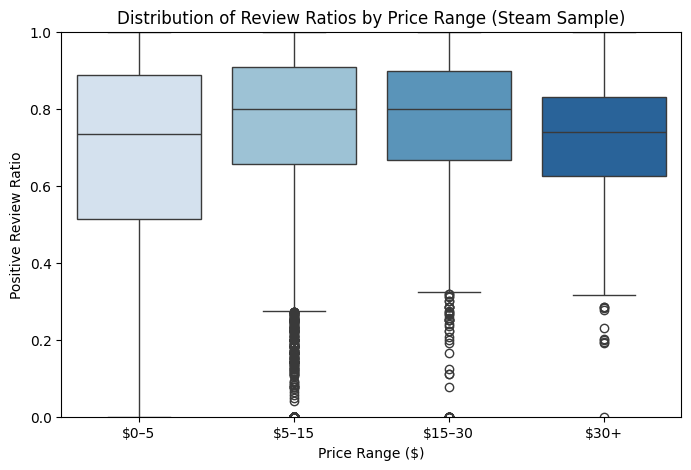

In [50]:
# Q3 (continued): Explore price ranges for deeper insight

# Create price bins
steam_sample['price_bin'] = pd.cut(
    steam_sample['price'],
    bins=[0, 5, 15, 30, 60],
    labels=['$0–5', '$5–15', '$15–30', '$30+']
)

# Compute average review ratio per price range
avg_by_bin = steam_sample.groupby('price_bin')['review_ratio'].mean().reset_index()

# Display averages
print("Average review ratio by price range:")
print(avg_by_bin.round(3))

# Visualize distribution
plt.figure(figsize=(8, 5))
sns.boxplot(x='price_bin', y='review_ratio', data=steam_sample, palette='Blues')
plt.title("Distribution of Review Ratios by Price Range (Steam Sample)")
plt.xlabel("Price Range ($)")
plt.ylabel("Positive Review Ratio")
plt.ylim(0, 1)
plt.show()

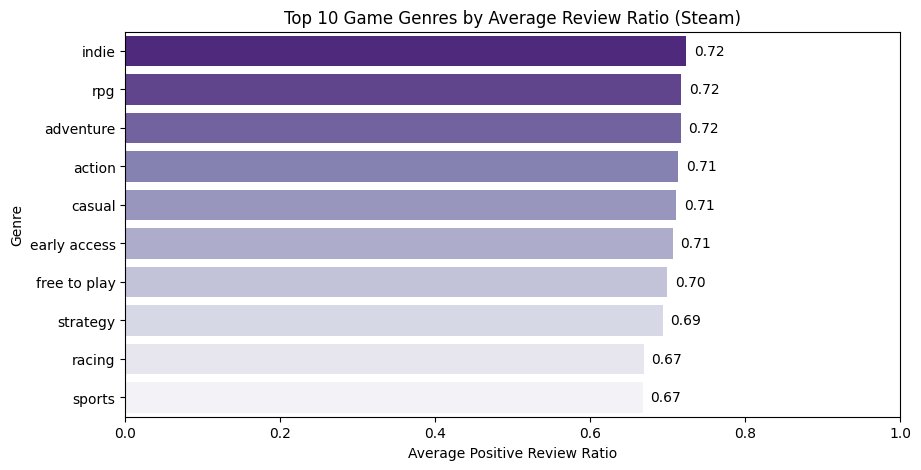

In [51]:
# Q4: Which game genres have the highest average review ratio? (Steam Sample)

# Recalculate review ratio like in Q3
steam_sample['total_ratings'] = steam_sample['positive_ratings'] + steam_sample['negative_ratings']
steam_sample['review_ratio'] = steam_sample['positive_ratings'] / steam_sample['total_ratings']

# Split combined genres (so each game appears under all its genres)
steam_sample_split = steam_sample.copy()
steam_sample_split['genre'] = steam_sample_split['genre'].astype(str).str.replace(';', ',')
steam_sample_split = steam_sample_split.assign(genre=steam_sample_split['genre'].str.split(','))
steam_sample_split = steam_sample_split.explode('genre')
steam_sample_split['genre'] = steam_sample_split['genre'].str.strip().str.lower()
steam_sample_split = steam_sample_split.dropna(subset=['genre']).reset_index(drop=True)

# Group by genre and calculate average review ratio
genre_review = (
    steam_sample_split.groupby('genre')['review_ratio']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
# Plot the results
plt.figure(figsize=(10,5))
sns.barplot(x=genre_review.values, y=genre_review.index, palette='Purples_r')

# Add value labels
for i, val in enumerate(genre_review.values):
    plt.text(val + 0.01, i, f"{val:.2f}", va='center')

plt.title("Top 10 Game Genres by Average Review Ratio (Steam)")
plt.xlabel("Average Positive Review Ratio")
plt.ylabel("Genre")
plt.xlim(0, 1)
plt.show()

Correlation between average rating and global sales: -0.035


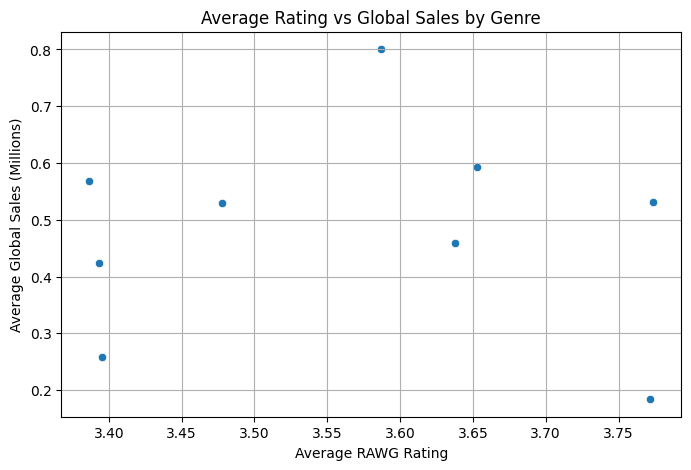

In [52]:
#5 Do higher-rated genres also sell better?
avg_rating = rawg.groupby('genre')['rating'].mean().reset_index()

# Average global sales per genre from vgsales
avg_sales = sales.groupby('genre')['global_sales'].mean().reset_index()

# Merge them
merged = pd.merge(avg_rating, avg_sales, on='genre', how='inner')

# Correlation + scatter plot
corr = merged['rating'].corr(merged['global_sales'])
print(f"Correlation between average rating and global sales: {corr:.3f}")

plt.figure(figsize=(8,5))
sns.scatterplot(data=merged, x='rating', y='global_sales')
plt.title("Average Rating vs Global Sales by Genre")
plt.xlabel("Average RAWG Rating")
plt.ylabel("Average Global Sales (Millions)")
plt.grid(True)
plt.show()

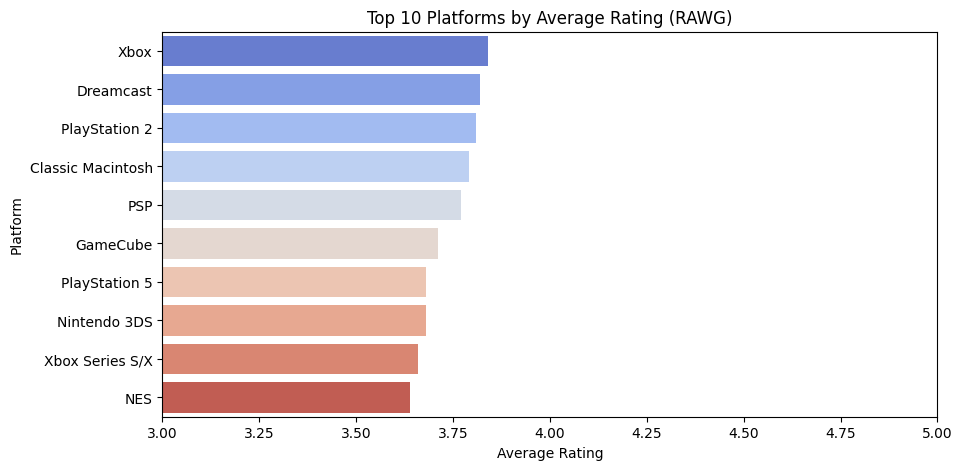

In [53]:
#6 How do average ratings differ across gaming platforms?

rawg_platforms = rawg.assign(platform=rawg['platforms'].str.split(','))
rawg_platforms = rawg_platforms.explode('platform')
rawg_platforms['platform'] = rawg_platforms['platform'].str.strip()

platform_ratings = (
    rawg_platforms.groupby('platform')['rating']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .round(2)
)

plt.figure(figsize=(10,5))
sns.barplot(x=platform_ratings.values, y=platform_ratings.index, palette='coolwarm')
plt.title("Top 10 Platforms by Average Rating (RAWG)")
plt.xlabel("Average Rating")
plt.ylabel("Platform")
plt.xlim(3,5)
plt.show()

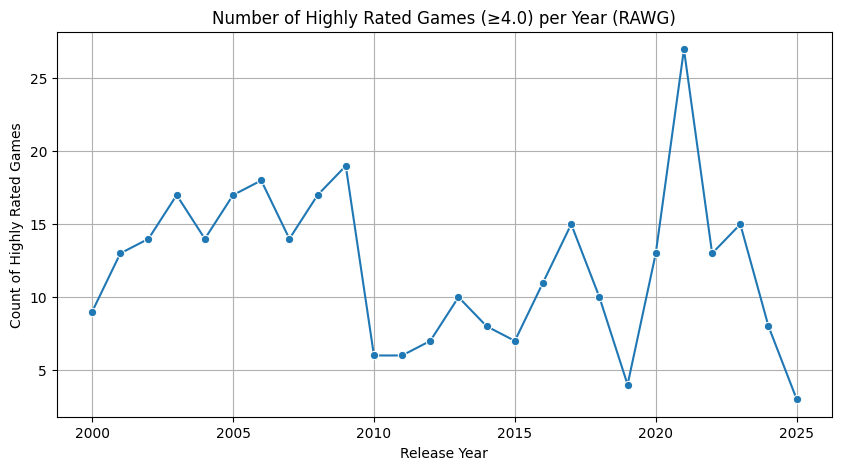

In [54]:
#7 Which years had the highest number of highly rated games?
high_rated_per_year = rawg[rawg['rating'] >= 4.0].groupby('year').size()

plt.figure(figsize=(10,5))
sns.lineplot(x=high_rated_per_year.index, y=high_rated_per_year.values, marker='o')
plt.title("Number of Highly Rated Games (≥4.0) per Year (RAWG)")
plt.xlabel("Release Year")
plt.ylabel("Count of Highly Rated Games")
plt.grid(True)
plt.show()

In [55]:
#MODEL
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Merge average metrics by genre
merged_all = pd.merge(avg_sales, avg_rating, on='genre', how='inner')
steam_price = steam.groupby('genre')['price'].mean().reset_index()
merged_all = pd.merge(merged_all, steam_price, on='genre', how='inner')

# Encode categorical variable (genre)
encoder = LabelEncoder()
merged_all['genre_encoded'] = encoder.fit_transform(merged_all['genre'])

# Prepare features (X) and target (y)
X = merged_all[['rating', 'price', 'genre_encoded']]
y = merged_all['global_sales']

# Split and fit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"R² score: {r2:.3f}")
print("Coefficients:", dict(zip(X.columns, model.coef_)))


R² score: -5.583
Coefficients: {'rating': np.float64(-0.5725399853199059), 'price': np.float64(0.04293220517418801), 'genre_encoded': np.float64(-0.15956045435727914)}


(6, 5)
genre            0
global_sales     0
rating           0
price            0
genre_encoded    0
dtype: int64
       global_sales    rating      price  genre_encoded
count      6.000000  6.000000   6.000000       6.000000
mean       0.431937  3.553662  10.713757       2.500000
std        0.171034  0.157027   1.681074       1.870829
min        0.184013  3.386667   8.733850       0.000000
25%        0.308467  3.415744  10.088427       1.250000
50%        0.494050  3.557735  10.449279       2.500000
75%        0.558592  3.649252  10.776194       3.750000
max        0.592798  3.771667  13.796825       5.000000


<Axes: ylabel='Frequency'>

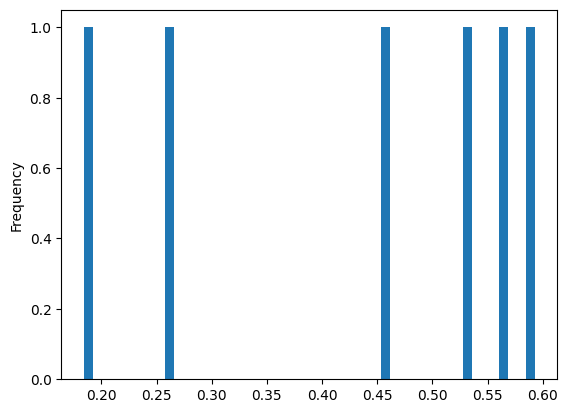

In [56]:
print(merged_all.shape)                  # how many rows did you model on?
print(merged_all.isna().sum())           # any NaNs slipping in?
print(merged_all.describe())             # sanity on ranges
merged_all['global_sales'].plot(kind='hist', bins=50)  # check skew

Steam dataset after strict cleaning: (5924, 21)

R² Score: 0.092
RMSE: 0.170

Predictor importance (higher absolute value = stronger effect):
            Feature  Coefficient
5          platform     0.037388
0             price     0.033047
7         publisher     0.007566
3            owners     0.007358
1  average_playtime     0.004204
6        categories     0.003887
2   median_playtime    -0.001276
4             genre    -0.002096


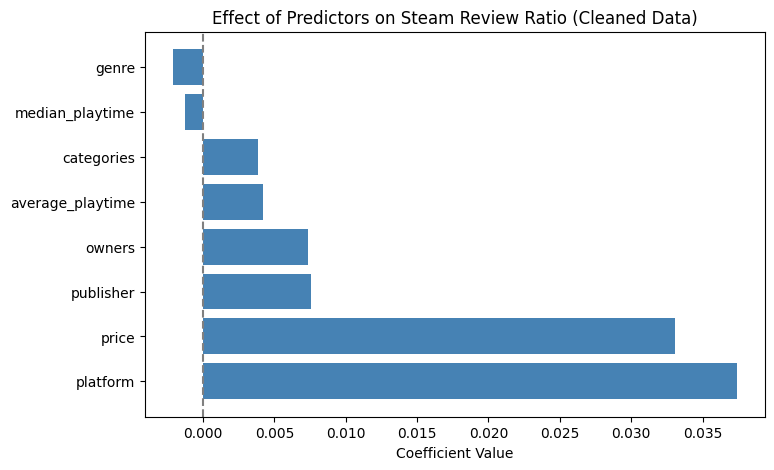

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# 1️⃣ Load data
steam = pd.read_csv("data/steam_clean.csv")

# 2️⃣ Strict filtering – remove rows with 0 or missing key metrics
steam = steam[
    (steam["price"] >= 0) &
    (steam["average_playtime"] > 0) &
    (steam["median_playtime"] > 0) &
    (steam["positive_ratings"] > 0) &
    (steam["negative_ratings"] > 0) &
    (steam["owners"].notna()) &
    (steam["publisher"].notna())
].copy()

# 3️⃣ Derived columns
steam["total_reviews"] = steam["positive_ratings"] + steam["negative_ratings"]
steam["review_ratio"] = steam["positive_ratings"] / steam["total_reviews"]

# Clean and convert owners (e.g. "20,000 - 50,000")
steam["owners"] = steam["owners"].astype(str).str.replace(",", "")
steam["owners_low"] = steam["owners"].apply(lambda x: x.split("-")[0] if "-" in x else x)
steam["owners_low"] = pd.to_numeric(steam["owners_low"], errors="coerce")

print("Steam dataset after strict cleaning:", steam.shape)

# 4️⃣ Select variables
X = steam[[
    "price", "average_playtime", "median_playtime", "owners_low",
    "genre", "platforms", "categories", "publisher"
]].copy()
y = steam["review_ratio"]

# 5️⃣ Encode categorical variables
le_genre = LabelEncoder()
le_platform = LabelEncoder()
le_categories = LabelEncoder()
le_publisher = LabelEncoder()

X.loc[:, "genre_encoded"] = le_genre.fit_transform(X["genre"].astype(str))
X.loc[:, "platform_encoded"] = le_platform.fit_transform(X["platforms"].astype(str))
X.loc[:, "categories_encoded"] = le_categories.fit_transform(X["categories"].astype(str))
X.loc[:, "publisher_encoded"] = le_publisher.fit_transform(X["publisher"].astype(str))

X = X[[
    "price", "average_playtime", "median_playtime", "owners_low",
    "genre_encoded", "platform_encoded", "categories_encoded", "publisher_encoded"
]]

# 6️⃣ Scale numeric variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7️⃣ Train-test split & model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# 8️⃣ Evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nR² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# 9️⃣ Coefficients
coeffs = pd.DataFrame({
    "Feature": [
        "price", "average_playtime", "median_playtime", "owners",
        "genre", "platform", "categories", "publisher"
    ],
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\nPredictor importance (higher absolute value = stronger effect):")
print(coeffs)

# 🔟 Visualization
plt.figure(figsize=(8, 5))
plt.barh(coeffs["Feature"], coeffs["Coefficient"], color="steelblue")
plt.title("Effect of Predictors on Steam Review Ratio (Cleaned Data)")
plt.xlabel("Coefficient Value")
plt.axvline(0, color="gray", linestyle="--")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# 1) Load
steam = pd.read_csv("data/steam_clean.csv")
sales = pd.read_csv("data/vgsales_clean.csv")

# 2) Normalize obvious column names (ignore missing keys)
sales = sales.rename(columns={
    "Genre": "genre",
    "Platform": "platform",
    "Publisher": "publisher",
    "Global_Sales": "global_sales",
    "Name": "name",
    "Year": "year",
}, errors="ignore")

steam = steam.rename(columns={
    "genres": "genre",
    "platforms": "platform",     # steam has 'platforms' originally; standardize to 'platform'
    "publisher": "publisher",    # just to be explicit
}, errors="ignore")

# 3) Strict cleaning
# Steam: remove zeros/missing for key fields we’ll use
steam = steam[
    (steam["price"] > 0) &
    (steam["average_playtime"] > 0) &
    (steam["median_playtime"] > 0) &
    (steam["positive_ratings"] > 0) &
    (steam["negative_ratings"] > 0) &
    (steam["owners"].notna())
].copy()

# Sales: keep valid rows with positive sales and usable genre/platform
sales = sales[
    (sales["global_sales"] > 0) &
    (sales["genre"].notna()) &
    (sales["platform"].notna())
].copy()

# 4) Steam derived fields
steam["total_reviews"] = steam["positive_ratings"] + steam["negative_ratings"]
steam["review_ratio"] = steam["positive_ratings"] / steam["total_reviews"]

# owners is a range like "20,000 - 50,000": take low end
steam["owners"] = steam["owners"].astype(str).str.replace(",", "")
steam["owners_low"] = steam["owners"].apply(
    lambda x: x.split("-")[0] if "-" in x else x
)
steam["owners_low"] = pd.to_numeric(steam["owners_low"], errors="coerce")

# 5) Standardize genres across both datasets
def simplify_genre(g):
    if pd.isna(g): 
        return np.nan
    g = str(g).lower()
    if "action" in g: return "action"
    if "adventure" in g: return "adventure"
    if "rpg" in g or "role" in g: return "rpg"
    if "strategy" in g: return "strategy"
    if "simulation" in g: return "simulation"
    if "sports" in g: return "sports"
    if "racing" in g: return "racing"
    if "puzzle" in g: return "puzzle"
    if "shooter" in g: return "shooter"
    if "casual" in g: return "casual"
    if "indie" in g: return "indie"
    return "other"

steam["genre_std"] = steam["genre"].apply(simplify_genre)
sales["genre_std"] = sales["genre"].apply(simplify_genre)

# Optional: drop rows with unknown genre after simplification
steam = steam[steam["genre_std"].notna()]
sales = sales[sales["genre_std"].notna()]

# 6) Merge on standardized genre
merged = pd.merge(
    sales, steam,
    on="genre_std",
    how="inner",
    suffixes=("_sales", "_steam")
)

print("Merged dataset:", merged.shape)
print("Columns in merged:", list(merged.columns))

# 7) Resolve column names robustly
def pick_col(candidates, df):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Prefer Steam-side platform/categories/publisher if present
platform_col   = pick_col(["platform_steam", "platform"], merged)
categories_col = pick_col(["categories_steam", "categories"], merged)
publisher_col  = pick_col(["publisher_steam", "publisher"], merged)

# 8) Build feature set dynamically
feature_cols = ["price", "average_playtime", "median_playtime", "owners_low", "review_ratio"]
cat_cols = []
if platform_col is not None:   cat_cols.append(platform_col)
if categories_col is not None: cat_cols.append(categories_col)
if publisher_col is not None:  cat_cols.append(publisher_col)

missing = [c for c in feature_cols if c not in merged.columns]
if missing:
    print("Warning: missing numeric features in merged:", missing)

X_num = merged[[c for c in feature_cols if c in merged.columns]].copy()
y = merged["global_sales"]

# Encode categorical vars if present
encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    X_num[c + "_enc"] = le.fit_transform(merged[c].astype(str))
    encoders[c] = le

# Final X with encoded categories
X = X_num.copy()

# 9) Scale & split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

# 10) Evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nR² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# 11) Coefficients with readable names
final_feature_names = list(X.columns)  # after encodings added
coeffs = pd.DataFrame({
    "Feature": final_feature_names,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\nPredictor importance (higher absolute value = stronger effect):")
print(coeffs)

# 12) Plot
plt.figure(figsize=(9, 6))
plt.barh(coeffs["Feature"], coeffs["Coefficient"])
plt.title("Effect of Steam Features on Global Sales")
plt.xlabel("Coefficient (Linear Regression)")
plt.axvline(0, color="gray", linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()
